# MASH Prediction By Logistic Regression
Author: Nana K. Owusu

Metabolic-dysfunction Associated Steatotic Liver Disease (MASLD) is a chronic liver disease with a mild form known as
simple steatosis (macroscopic droplets of fat deposited in liver cells, MASLD) and a severe, progrossive form known as 
steatoshepatitis (inflammation and cellular injury in liver tissue, MASH). As the liver continues to store fat in its functional
cells, a physiologic response leads to the deposition of fibrotic molecules in the extra-cellular matrix (fibrosis).
Inflammation can also occur as a physiologic response to the stress, as well as cellular injury, where liver cells break
apart due to excess fat deposition. In clinical practice, patients with fibrosis grade 2 along with histologic proof of
inflammation and cellular injury are said to be at risk of irreversible damage to the liver (high-risk MASH). 

Magnetic resonance elastography (MRE) is the imaging technique that allows for non-invasive assesment of mechanical properties
of biological tissue. This includes measures of elastic properties like storage modulus and shear stiffness as well as 
viscous properties like loss modulus and dampring ratio. Since MASLD does change the mechanical properties of tissue, MRE 
provides accurate biomarkers that reflect fibrosis stage (shear stiffness) and inflammation (damping ratio). Proton density
fat fraction (PDFF) is also an accurate measure of fat content, deriving values from protons attached to fat molecules.

This notebook showcases the predictive capacity of a these MRI biomarkers as predictors in logistic regression models.

### Initial libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import import_module, reload
from timeit import default_timer as timer
%matplotlib inline

In [2]:
from sys import path
path.append('/Users/nowusu/GitHub_repos/ml_portfolio/MASLD_prediction/')

import ml_lib
# ml_lib = reload(ml_lib)
from ml_lib import (roc_plot, classification_metrics, LOO_testing, calc_auc, DeLong2_test,
                   final_training)

### Getting and Cleaning the Data

In [3]:
data=pd.read_csv('/Users/nowusu/GitHub_repos/ml_portfolio/MASLD_prediction/NAFLD-four-cohorts_20220413.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cohort        510 non-null    object 
 1   ID            510 non-null    object 
 2   Steatosis     487 non-null    float64
 3   Inflammation  399 non-null    float64
 4   Ballooning    469 non-null    float64
 5   Fibrosis      496 non-null    float64
 6   NAS           466 non-null    float64
 7   NASH          488 non-null    object 
 8   NASH(0-2)     399 non-null    float64
 9   NASH-F2       399 non-null    float64
 10  NASH(0-1)     488 non-null    float64
 11  PDFF          504 non-null    float64
 12  LS-2D-60      499 non-null    float64
 13  LS-3D-60      396 non-null    float64
 14  DR-3D-60      396 non-null    float64
 15  SM-3D-60      396 non-null    float64
 16  LM-3D-60      396 non-null    float64
 17  LS-3D-40      386 non-null    float64
 18  DR-3D-40      386 non-null    

In [4]:
#SELECTING RELEVANT COLUMNS
cols_3Dmre = ['Steatosis','Inflammation','Ballooning',
              'NASH(0-1)','Fibrosis','PDFF',
              'LS-3D-60','DR-3D-60','SM-3D-60', 'LM-3D-60']
data=data[cols_3Dmre]

data.dropna(inplace=True)

#ADDING TARGET COLUMNS
# create categorcial column for fibrosis grade greater than 1
data['Fib_gt1'] = data['Fibrosis'].apply(lambda x: int(x>1))

# create categorical column for patients with high-risk MASH,
# (HRM = MASH ^ Fib_gt1)
data['HRM'] = data['NASH(0-1)'].astype('int16') & data['Fib_gt1']

data.rename({'LS-3D-60':'SS','DR-3D-60':'DR',
            'SM-3D-60':'SM','LM-3D-60':'LM',
            'NASH(0-1)':'MASH_gt0'},axis=1, inplace=True)

#RESETTING INDEX
data.reset_index(drop=True, inplace=True)

#### Export cleaned data to excel

In [5]:
#SUMMARY
print('\nDATA TYPES:\n-----------')
print(data.dtypes)
print('\nMISSING VALUES:\n---------------')
print(data.isna().sum())
print('\nDIMENSIONS:\n---------------')
print(data.shape)
data.head()


DATA TYPES:
-----------
Steatosis       float64
Inflammation    float64
Ballooning      float64
MASH_gt0        float64
Fibrosis        float64
PDFF            float64
SS              float64
DR              float64
SM              float64
LM              float64
Fib_gt1           int64
HRM               int64
dtype: object

MISSING VALUES:
---------------
Steatosis       0
Inflammation    0
Ballooning      0
MASH_gt0        0
Fibrosis        0
PDFF            0
SS              0
DR              0
SM              0
LM              0
Fib_gt1         0
HRM             0
dtype: int64

DIMENSIONS:
---------------
(379, 12)


,Steatosis,Inflammation,Ballooning,MASH_gt0,Fibrosis,PDFF,SS,DR,SM,LM,Fib_gt1,HRM
0,2.0,2.0,1.0,1.0,0.0,15.58,1.982085,0.093943,1.948,0.366,0,0
1,2.0,2.0,1.0,1.0,1.0,28.99,2.449648,0.075764,2.422,0.367,0,0
2,2.0,2.0,1.0,1.0,0.5,11.71,2.780881,0.064540,2.758,0.356,0,0
3,1.0,1.0,1.0,1.0,2.0,10.64,2.482754,0.036955,2.476,0.183,1,1
4,1.0,1.0,1.0,1.0,0.5,4.69,3.172105,0.040006,3.162,0.253,0,0


### Machine Learning
#### Initialization

In [18]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score
from statsmodels.stats.contingency_tables import mcnemar

In [7]:
#DEFINING GLOBAL ML PARAMETERS
Cs = np.logspace(-4,4,9)
cv = LeaveOneOut()
scoring = 'accuracy'
solver = 'liblinear'
tol = 1e-6
max_iter = int(1e6)
class_weight = 'balanced'

#DEFINING TARGETS
# HRM is high-risk MASH a designation for those with positive MASH diagnosis by biopsy,
# concomitant with fibrosis at stage 2 or above
# MASH_gt0 is the positive diagnosis for metabolic dysfunction associated steatotic
# liver disease via liver biopsy.
targets = ['HRM']

#DEFINING MODELS
models = {'SS':['SS'],
          'FF':['PDFF'],
          'SSFFDR':['SS','PDFF','DR']}

#DEFINING METRICS DATAFRAME
metric_cols = ['target','model','AUC','AUC_L','AUC_U','TP','FP','TN','FN',
               'sens','sens_L','sens_U','spec','spec_L','spec_U','NPV',
               'NPV_L','NPV_U','PPV','PPV_L','PPV_U']
metric_cols = metric_cols+[f"MN_p_{model}" for model in models.keys()]+[f"DL_p_{model}" for model in models.keys()]
metrics = pd.DataFrame(columns=metric_cols)

#### Bootstrapped Training, Validation, and Testing

Here, an equivalent of Leave-two-out cross-validation (CV) with N-1 of the dataset is passed to the LogsiticRegressionCV 
constructor with leave-one-out as the CV option. Assessment of the predictions (bootstrapping) made by the logistic regression 
is done using area-under-the-curve (AUC) and confidence interval derived from binomial distribution on the data.

In [8]:
#TESTING PERFORMANCE OF EACH MODEL
#Initialization
alpha=0.05
start = timer()
#Looping Over Models and Targets
for target in targets:
    for model in models:
        #Initializing Logistic Regression Model
        clf=LogisticRegressionCV(Cs=Cs,cv=cv,scoring=scoring,solver=solver, \
                                 tol=tol,max_iter=max_iter,class_weight=class_weight)
        
        #Defining Features and Target
        X = data[models[model]]
        Y = data[target]
        
        #Defining Output Columns
        data[target+'_'+model+'_proba'] = np.nan
        data[target+'_'+model+'_pred'] = np.nan
        
        #Computing Test Predictions
        LOO_testing(data, target, model, X, Y, clf)
        
        ##Bootstrap
        #Test AUC
        AUC_L, AUC, AUC_U = calc_auc(data, Y, data[target+'_'+model+'_proba'], alpha)
        
        #Test Classification Metrics
        cmatrix_dict = classification_metrics(data, Y, data[target+'_'+model+'_pred'], 
                                              alpha)
        
        #Storing Results
        new_row={'target':target,'model':model,
                 'AUC':AUC,'AUC_L':AUC_L,'AUC_U':AUC_U}
        new_row.update(cmatrix_dict)
        metrics = pd.concat([metrics, pd.DataFrame([new_row])], ignore_index=True)
        
end = timer()

mins, secs = divmod(end - start, 60)
hrs, mins = divmod(mins, 60)
print(f'elapsed time: {hrs} hr {mins} min {round(secs, 2)} sec')

/var/folders/k9/2h69mqhn6zg5qg90v8137ldc0000gn/T/ipykernel_56266/614327158.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, pd.DataFrame([new_row])], ignore_index=True)


elapsed time: 0.0 hr 27.0 min 55.55 sec


### Evaluation
#### Exact McNemar Test of Sensitivities

In [9]:
for model1 in models:
    k=0
    for target in targets:
        for model2 in models:
            #Labeling Positive Cohort Predictions Correct/Incorrect
            TP1=data[target+'_'+model1+'_pred'][data[target]==1]
            TP2=data[target+'_'+model2+'_pred'][data[target]==1]
            ctable=np.array([[((TP1==1)&(TP2==1)).sum(),((TP1==1)&(TP2==0)).sum()],\
                             [((TP1==0)&(TP2==1)).sum(),((TP1==0)&(TP2==0)).sum()]])
            
            #Different Models
            if model1!=model2:
                metrics.loc[k,'MN_p_'+model1]=mcnemar(ctable,exact=True).pvalue
            
            #Same Model
            else:
                metrics.loc[k,'MN_p_'+model1]=np.nan
            
            #Row Iterator
            k+=1
metrics

,target,model,AUC,AUC_L,AUC_U,TP,FP,TN,FN,sens,...,NPV_U,PPV,PPV_L,PPV_U,MN_p_SS,MN_p_FF,MN_p_SSFFDR,DL_p_SS,DL_p_FF,DL_p_SSFFDR
0,HRM,SS,0.860825,0.809638,0.912011,58,42,249,30,0.659091,...,0.926267,0.580000,0.477119,0.678014,NaN,0.029305,0.607239,NaN,NaN,NaN
1,HRM,FF,0.579663,0.509897,0.649428,42,118,173,46,0.477273,...,0.841925,0.262500,0.196197,0.337820,0.029305,NaN,0.003378,NaN,NaN,NaN
2,HRM,SSFFDR,0.853561,0.801301,0.905822,61,55,236,27,0.693182,...,0.931248,0.525862,0.431055,0.619317,0.607239,0.003378,NaN,NaN,NaN,NaN


#### Delong Test of AUCs

In [10]:
for model1 in models:
    k=0
    for target in targets:
        for model2 in models:
            #Different Models
            if model1!=model2:
                X1=np.array((data[target+'_'+model1+'_proba'])[data[target]==1])
                Y1=np.array((data[target+'_'+model1+'_proba'])[data[target]==0])
                X2=np.array((data[target+'_'+model2+'_proba'])[data[target]==1])
                Y2=np.array((data[target+'_'+model2+'_proba'])[data[target]==0])
                metrics.loc[k,'DL_p_'+model1] = DeLong2_test(X1,Y1,X2,Y2)[1]
                
            #Same Model
            else:
                metrics.loc[k,'DL_p_'+model1]=np.nan
                
            #Row Iterator
            k+=1
metrics

,target,model,AUC,AUC_L,AUC_U,TP,FP,TN,FN,sens,...,NPV_U,PPV,PPV_L,PPV_U,MN_p_SS,MN_p_FF,MN_p_SSFFDR,DL_p_SS,DL_p_FF,DL_p_SSFFDR
0,HRM,SS,0.860825,0.809638,0.912011,58,42,249,30,0.659091,...,0.926267,0.580000,0.477119,0.678014,NaN,0.029305,0.607239,NaN,0.0,0.293887
1,HRM,FF,0.579663,0.509897,0.649428,42,118,173,46,0.477273,...,0.841925,0.262500,0.196197,0.337820,0.029305,NaN,0.003378,0.0,NaN,0.0
2,HRM,SSFFDR,0.853561,0.801301,0.905822,61,55,236,27,0.693182,...,0.931248,0.525862,0.431055,0.619317,0.607239,0.003378,NaN,0.293887,0.0,NaN


#### ROC Curves

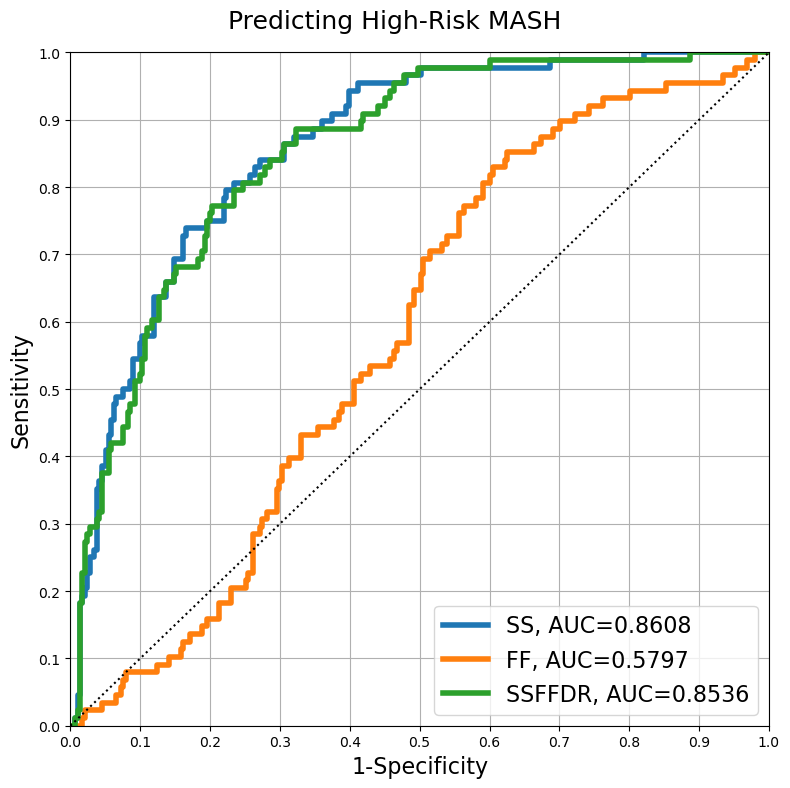

In [26]:
hrm_fig = plt.figure(figsize=(8,8))
hrm_fig.add_subplot()
roc_plot(hrm_fig, data, 'HRM', ['SS','FF','SSFFDR'], 'Predicting High-Risk MASH')

### Final Model Training

In [20]:
#INITIALIZATION
clfs={target:{model:LogisticRegressionCV(Cs=Cs,cv=cv,scoring=scoring,solver=solver,tol=tol,max_iter=max_iter,
                                         class_weight=class_weight) for model in models} for target in targets}

model_keys = {'SS':['SS'],'FF':['FF'],
              'SSFFDR':['SS','FF','DR']}

final_cols=['target','model','AUC','intercept',
            'beta_SS','beta_DR','beta_FF',
            'beta_std_SS','beta_std_DR','beta_std_FF',
            'OR_std_SS','OR_std_DR','OR_std_FF']
final=pd.DataFrame(columns=final_cols)

In [24]:
final_training(data, final, targets, models, model_keys, clfs)
final

,target,model,AUC,intercept,beta_SS,beta_DR,beta_FF,beta_std_SS,beta_std_DR,beta_std_FF,OR_std_SS,OR_std_DR,OR_std_FF
0,HRM,SS,0.864105,-3.483989,1.269103,NaN,NaN,1.325992,NaN,NaN,3.765921,NaN,NaN
1,HRM,FF,0.591358,-0.348216,NaN,NaN,0.026281,NaN,NaN,0.241398,NaN,NaN,1.273027
2,HRM,SSFFDR,0.866995,-4.037549,1.588897,-8.433561,0.044512,1.660122,-0.345204,0.408856,5.259951,0.708076,1.505095
